# DIOMIRA-NB-XenonPreprocStudy-10-01-16

## Study of Kr (5bar, Xenon) sample file previous to MC production

In [2]:
from __future__ import print_function

In [3]:
from IPython.display import Image

In [4]:
%matplotlib inline

In [5]:
%load_ext autoreload

In [6]:
%autoreload 2

#### Expect a environment variable ICDIR pointing to the IC root directory

In [7]:
ic = %env ICDIR

In [8]:
ic

'/Users/jjgomezcadenas/Documents/Development/NEXT/IC'

In [9]:
import logging
import sys
logger = logging.getLogger()
logger.handlers[0].stream = sys.stdout
logger.setLevel(logging.DEBUG)

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import tables 
import numpy as np

In [11]:
import mplFunctions as mpl
import wfmFunctions as wfm
from Util import *

In [12]:
import FEParam as FP

In [13]:
import cProfile

In [14]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

In [15]:
import time

### DIOMIRA-NB revisited in:

In [16]:
print(time.strftime("%d/%m/%Y"))

01/10/2016


In [17]:
print(time.strftime("%H:%M:%S"))

18:03:49


### Checking prototype MC production 

In [17]:
%ls -lh /Users/jjgomezcadenas/Documents/Development/NEXT/data/test/

total 855416
-rw-r--r--  1 jjgomezcadenas  staff   1.6M Sep 27 21:16 dst_run_2033.root.h5
-rw-r--r--  1 jjgomezcadenas  staff   1.6M Sep 26 21:07 nexus_NEW_NEXT_v0_08_00_Kr_ACTIVE_5bar_1000kev_0.next.root.h5
-rw-r--r--  1 jjgomezcadenas  staff    77M Sep 27 19:24 nexus_NEW_NEXT_v0_08_00_Kr_ACTIVE_5bar_1000kev_0.next_1.root.h5
-rw-r--r--  1 jjgomezcadenas  staff   336M Sep 29 21:49 nexus_NEW_NEXT_v0_08_00_Kr_ACTIVE_5bar_1000kev_0.next_10000.root.h5
-rw-r--r--  1 jjgomezcadenas  staff   263K Sep 29 15:42 nexus_NEW_NEXT_v0_08_00_Kr_ACTIVE_5bar_1000kev_0.next_WN_10000.root
-rw-r--r--  1 jjgomezcadenas  staff   1.1M Sep 26 22:05 run_2033.gdc1next.000.next1el.root.h5


Prototype MC file has size 336 M

In [19]:
%ls -lh '/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/Kr_ACTIVE_5bar_evt_1000.h5'

-rw-r--r--  1 jjgomezcadenas  staff   992M Oct  1 11:59 /Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/Kr_ACTIVE_5bar_evt_1000.h5


MC + DIOMIRA (1000 events) 992 M

In [20]:
h5f =tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/Kr_ACTIVE_5bar_evt_1000.h5')

In [25]:
table_twf = h5f.root.TWF.TWF

In [26]:
pmtrwf = h5f.root.RD.pmtrwf

In [29]:
NPMT = pmtrwf.shape[1]

In [30]:
NPMT

12

In [23]:
def read_twf(table, event_number):
    """
    Reads back the TWF
    """
    
    PMT={}
    for row in table.where("event == event_number"):
        pmt = row['pmt']
        time_ns = row['time_ns'] 
        ene_pes =  row['ene_pes']
        
        #print('pmt = {},time_ns = {},ene_pes = {}'.format(pmt,time_ns,ene_pes))
        if pmt not in PMT:
            WF={}
            TIME =[]
            ENE = []
            TIME.append(time_ns)
            ENE.append(ene_pes)
            WF['time_ns'] = TIME
            WF['ene_pes'] = ENE
            PMT[pmt] = WF
        else:
            WF = PMT[pmt]
            TIME = WF['time_ns']
            ENE  = WF['ene_pes']
            TIME.append(time_ns)
            ENE.append(ene_pes)
                
    return PMT

In [73]:
read_twf(table_twf, event_number = 24)

{0L: {'ene_pes': [1212.0, 8.0], 'time_ns': [801404.8125, 805614.75]},
 1L: {'ene_pes': [1115.0], 'time_ns': [801450.9375]},
 2L: {'ene_pes': [1157.0], 'time_ns': [801437.0]},
 3L: {'ene_pes': [780.0], 'time_ns': [801650.4375]},
 4L: {'ene_pes': [729.0], 'time_ns': [801654.9375]},
 5L: {'ene_pes': [751.0], 'time_ns': [801300.125]},
 6L: {'ene_pes': [744.0], 'time_ns': [801709.6875]},
 7L: {'ene_pes': [735.0], 'time_ns': [800986.0]},
 8L: {'ene_pes': [729.0], 'time_ns': [800962.6875]},
 9L: {'ene_pes': [736.0], 'time_ns': [800890.375]},
 10L: {'ene_pes': [795.0], 'time_ns': [801291.875]},
 11L: {'ene_pes': [714.0], 'time_ns': [801531.3125]}}

In [25]:
def stat_twf(table, NPMT, event_list=[]):
    """
    Stats on the twf
    """
    PMTL = []
    for i in range(NPMT):
        PMT ={}
        energy_pes = np.zeros(len(event_list), dtype = np.float32)
        time_mus = np.zeros(len(event_list), dtype = np.float32)
        length_mus = np.zeros(len(event_list), dtype = np.int32)
        PMT['ene_pes'] = energy_pes
        PMT['time_mus'] = time_mus
        PMT['len_mus'] = length_mus
        PMTL.append(PMT)
    
    iev = 0
    for event_number in event_list:
        #print('event = {}'.format(iev))
        pmt_dict = read_twf(table, event_number)
        ipmt = 0
        for pmt in pmt_dict:
            PMT = PMTL[ipmt]
            
            PMT['ene_pes'][iev] = np.sum(pmt_dict[pmt]['ene_pes'])
            PMT['len_mus'][iev] = len(pmt_dict[pmt]['ene_pes'])
            PMT['time_mus'][iev] = np.mean(pmt_dict[pmt]['time_ns'])/mus
            ipmt +=1
        iev+=1
    return PMTL
            

In [75]:
pmtl = stat_twf(table_twf, NPMT, event_list=[0,1])

event = 0
event = 1


In [76]:
len(pmtl)

12

In [83]:
pmtl = stat_twf(table_twf, NPMT, event_list=range(10))

In [84]:
pmtl

[{'ene_pes': array([ 1101.,   870.,  1193.,  1017.,  1109.,  1109.,  1096.,  1057.,
           779.,   907.], dtype=float32),
  'len_mus': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32),
  'time_mus': array([  789.72589111,   885.66644287,   712.99499512,  1048.2019043 ,
           654.54772949,  1128.72033691,   639.98400879,   731.52191162,
           860.91772461,  1064.75866699], dtype=float32)},
 {'ene_pes': array([ 1063.,   967.,  1211.,  1006.,  1047.,  1120.,  1113.,  1133.,
           773.,   942.], dtype=float32),
  'len_mus': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32),
  'time_mus': array([  789.63708496,   885.49993896,   712.87713623,  1049.81408691,
           654.49243164,  1129.24414062,   640.03094482,   731.79223633,
           860.89941406,  1063.6652832 ], dtype=float32)},
 {'ene_pes': array([ 1115.,   899.,  1189.,  1030.,  1024.,  1092.,  1097.,  1175.,
           726.,   952.], dtype=float32),
  'len_mus': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=i

In [120]:
pmtl = stat_twf(table_twf, NPMT, event_list=range(1000))

In [28]:
def histo(x,bins,title='hsimple',xlabel = '', ylabel = 'Frequency'):
    """
    histograms
    """
    
    plt.hist(x, bins, histtype='bar', alpha=0.75)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

In [29]:
def histo_twf_ene(PMTL, emin = 0, emax = 2000, nbins = 20):
    """
    histogram energy in the PMTs
    """
    plt.figure(figsize=(20,20))
    
    for i in range(len(PMTL)):
        ax1 = plt.subplot(3,4,i+1)
        PMT = PMTL[i]
        bins = np.linspace(emin, emax, nbins)
        h_ene_pes = histo(PMT['ene_pes'],bins,title='energy_pes_pmt_'+str(i),xlabel = 'pes')
        
#     for i in range(len(PMTL)):
#         PMT = PMTL[i]
#         ene_pes = pd.Series(PMT['ene_pes'])
#         print('PMT number {}'.format(i))
#         #plt.figtext(1.0, 0.2, ene_pes.describe())
#         print(ene_pes.describe())
       
        
        

In [39]:
def stat_twf_ene(PMTL, emin = 0, emax = 2000):
    """
    histogram energy in the PMTs
    """
    EPMT = []
    for i in range(len(PMTL)):
        PMT = PMTL[i]
        ene_pes_lim = []
        indx_out = []
        j = 0
        for e in PMT['ene_pes']:
            if e >= emin and e < emax:
                ene_pes_lim.append(e)
            else:
                indx_out.append(j)
                #print('for PMT = {}, event = {}: found energy outside range: e = {} pes'.format(i,j,e))
            j+=1
        EPMT.append(indx_out)
        ene_pes = pd.Series(ene_pes_lim)
        print('PMT number {}'.format(i))
        print(ene_pes.describe())
    return EPMT
        

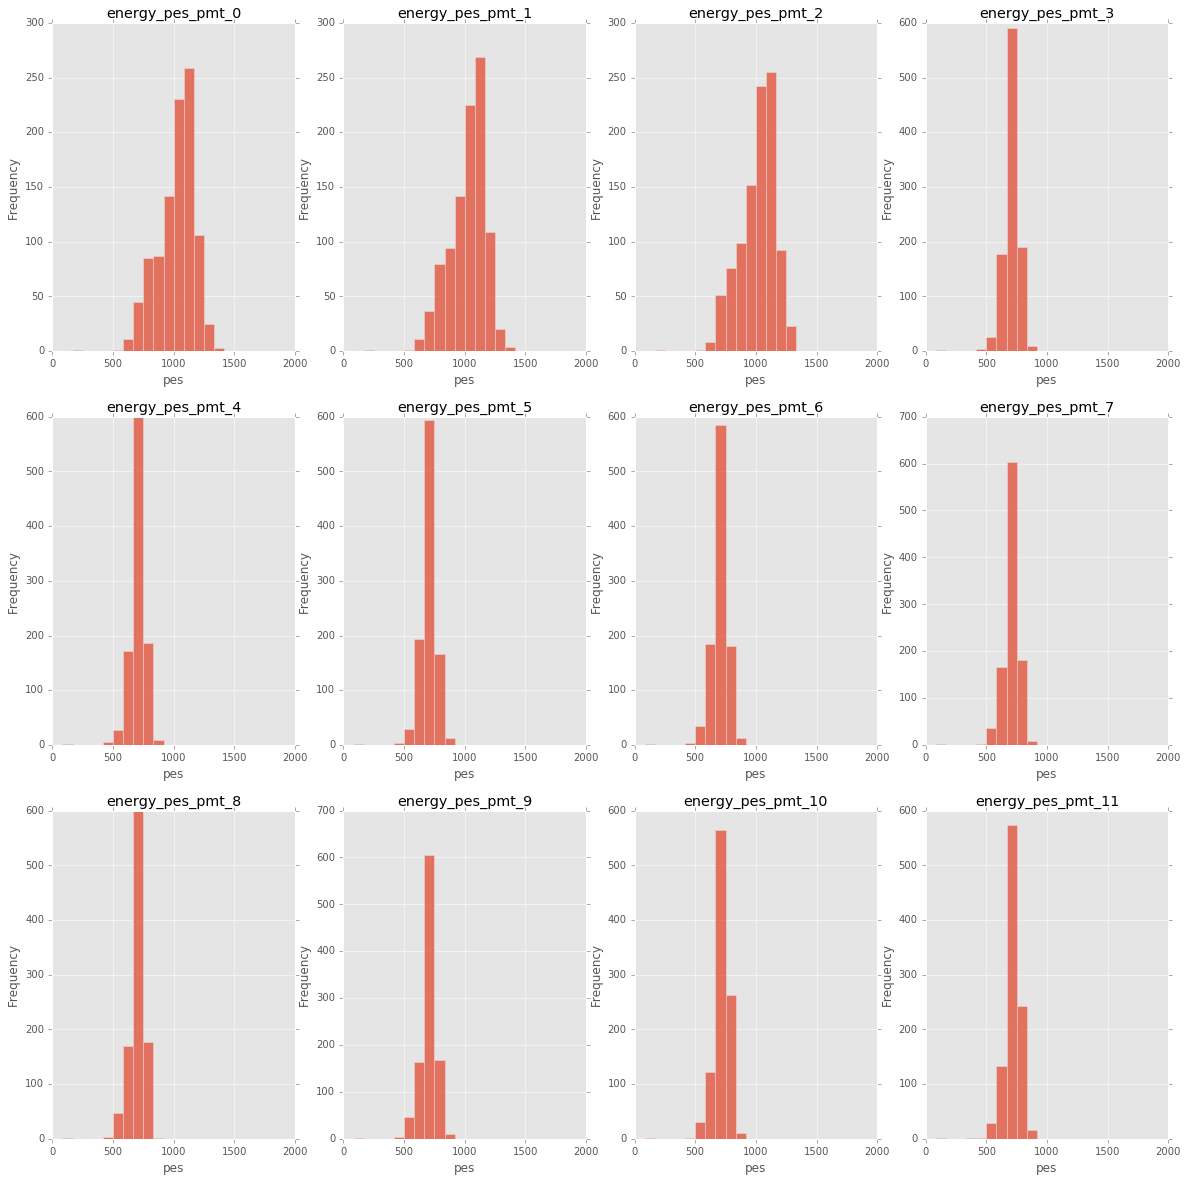

In [143]:
histo_twf_ene(pmtl,emin = 0, emax = 2000, nbins = 25)

In [147]:
outl = stat_twf_ene(pmtl,emin = 0, emax = 3000)

PMT number 0
count     995.000000
mean     1018.593970
std       147.609394
min       197.000000
25%       928.000000
50%      1049.000000
75%      1123.000000
max      1364.000000
dtype: float64
PMT number 1
count     993.000000
mean     1022.570997
std       147.658052
min       211.000000
25%       930.000000
50%      1051.000000
75%      1128.000000
max      1358.000000
dtype: float64
PMT number 2
count    1000.00000
mean     1012.31600
std       145.05284
min       182.00000
25%       923.00000
50%      1038.00000
75%      1119.25000
max      1316.00000
dtype: float64
PMT number 3
count    1000.000000
mean      704.420000
std        59.682356
min       137.000000
25%       671.000000
50%       708.500000
75%       740.250000
max       888.000000
dtype: float64
PMT number 4
count    1000.000000
mean      702.973000
std        59.593671
min       128.000000
25%       674.000000
50%       704.500000
75%       739.000000
max       881.000000
dtype: float64
PMT number 5
count    1000.0

In [148]:
outl

[[439, 456, 500, 559, 909],
 [299, 316, 424, 771, 793, 818, 824],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [82, 196, 276, 319, 535, 692],
 [923]]

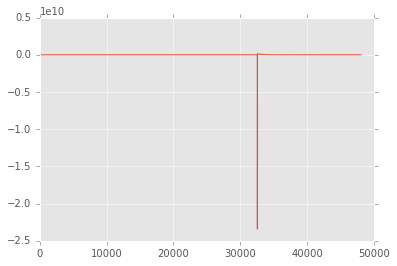

In [150]:
plt.plot(pmtrwf[439,0])

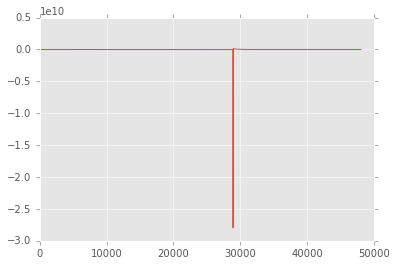

In [151]:
plt.plot(pmtrwf[456,0])

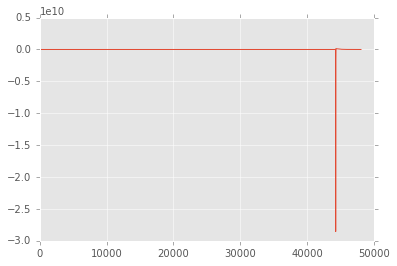

In [152]:
plt.plot(pmtrwf[923,11])

In [30]:
def histo_twf_len(PMTL, lmin = 0, lmax = 5, nbins = 5):
    """
    histogram len in the PMTs
    """
    plt.figure(figsize=(20,20))
    
    for i in range(len(PMTL)):
        ax1 = plt.subplot(3,4,i+1)
        PMT = PMTL[i]
        bins = np.linspace(lmin, lmax, nbins)
        h_len_mus = histo(PMT['len_mus'],bins,title='len_mus_pmt_'+str(i),xlabel = 'mus')
        

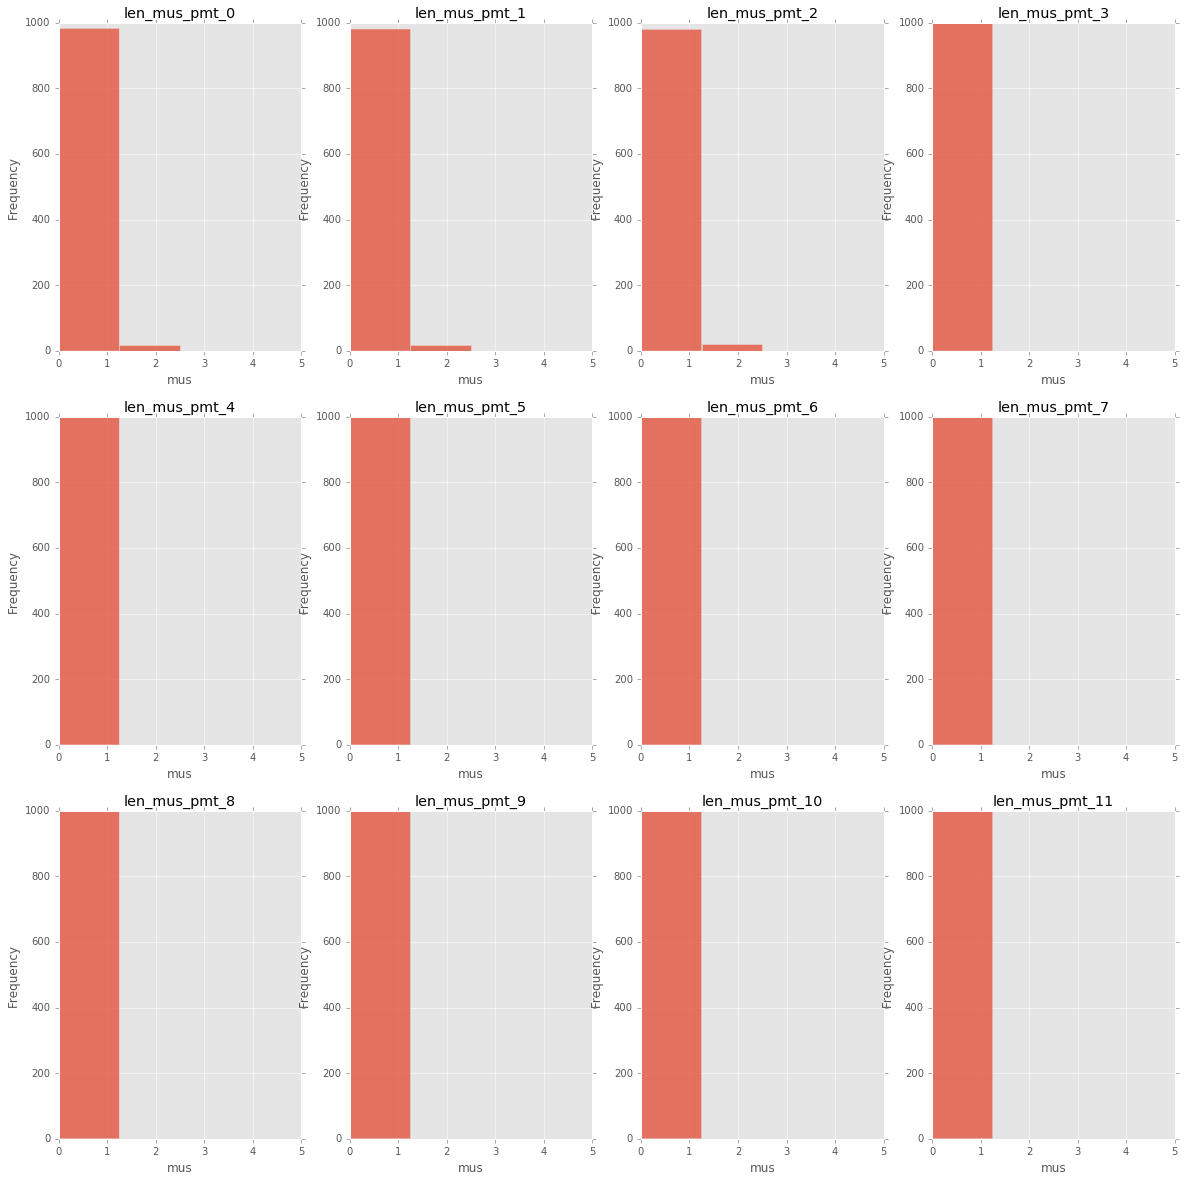

In [134]:
histo_twf_len(pmtl, lmin = 0, lmax = 5, nbins = 5)

In [31]:
def histo_twf_time(PMTL, tmin = 0, tmax = 1200, nbins = 20):
    """
    histogram len in the PMTs
    """
    plt.figure(figsize=(20,20))
    
    for i in range(len(PMTL)):
        ax1 = plt.subplot(3,4,i+1)
        PMT = PMTL[i]
        bins = np.linspace(tmin, tmax, nbins)
        h_len_mus = histo(PMT['time_mus'],bins,title='time_mus_pmt_'+str(i),xlabel = 'mus')
        

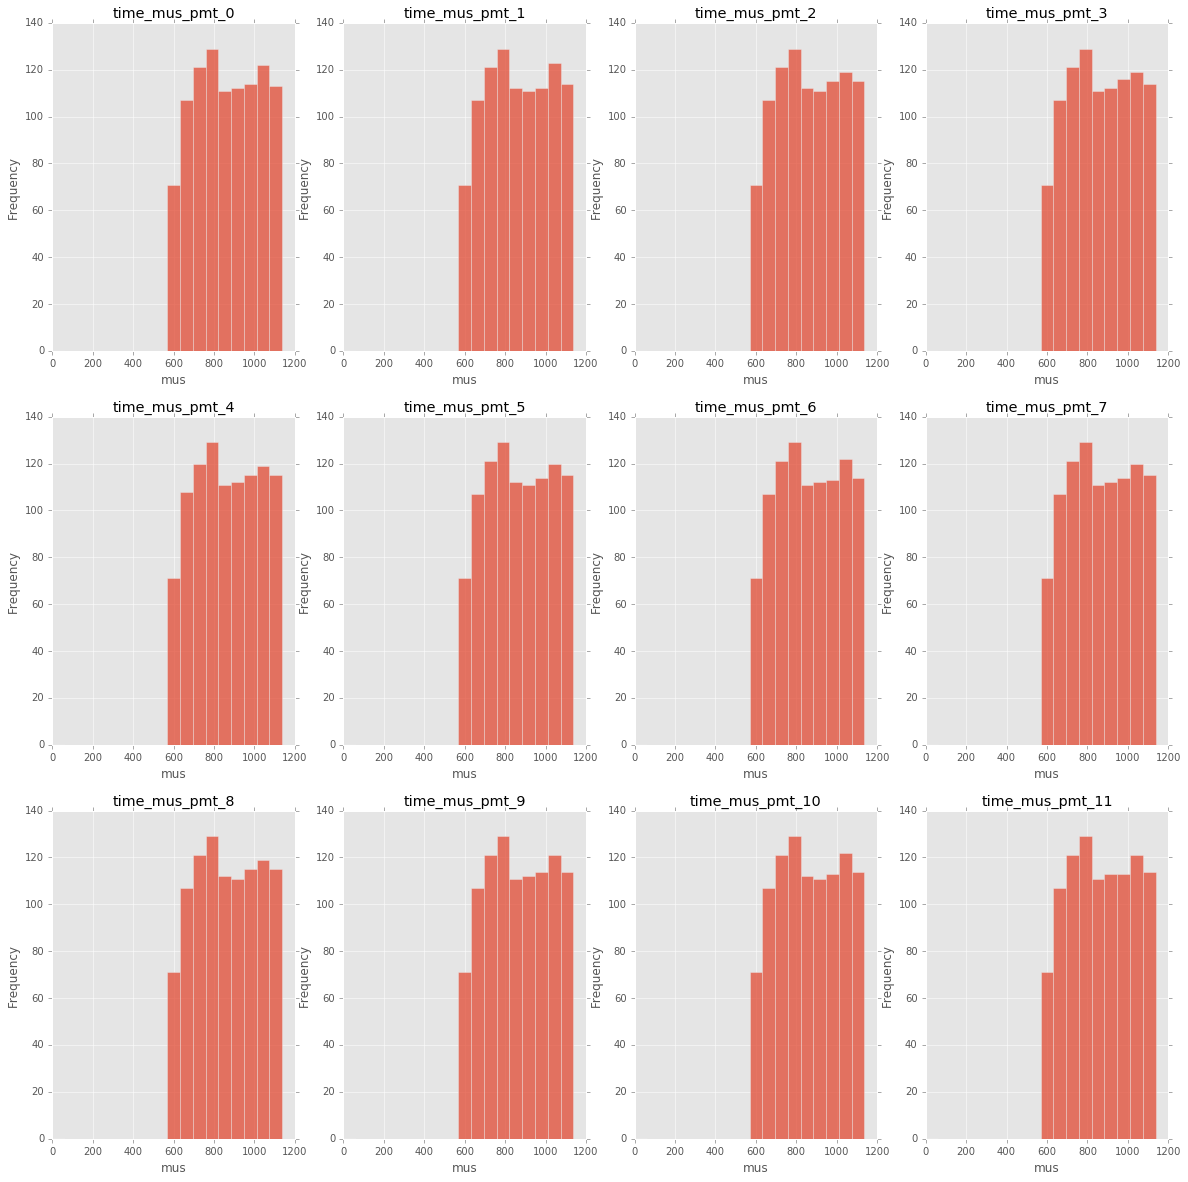

In [136]:
histo_twf_time(pmtl, tmin = 0, tmax = 1200, nbins = 20)

In [153]:
h5f.close()

### Status

In [155]:
import time

In [156]:
print(time.strftime("%d/%m/%Y"))
print(time.strftime("%H:%M:%S"))

01/10/2016
15:32:34


1. Issue found in some events (and some PMTs), MC energy values non-sense and corresponding RWF also screwed
2. Events occur only in the last 600 mus. One can therefore run 600 mus windows (both in Data an in MC)

In [ ]:
h5f =tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/WF_Na_ZLIB_test100_RWF.h5')

In [ ]:
pmtrwf = h5f.root.RD.pmtrwf

In [ ]:
mpl.scan_waveforms(pmtrwf,list_of_events=[1,10,20,50,99])

In [ ]:
h5f.close()

### Comparing new Kr prototype file with old (Na) prototype file 

In [18]:
h5f =tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/WF_Na_ZLIB_evt1000_RWF.h5')

In [19]:
pmtrwf = h5f.root.RD.pmtrwf

In [20]:
table_twf = h5f.root.TWF.TWF

In [21]:
NPMT = pmtrwf.shape[1]

In [22]:
NPMT

12

In [32]:
pmtl = stat_twf(table_twf, NPMT, event_list=range(1000))

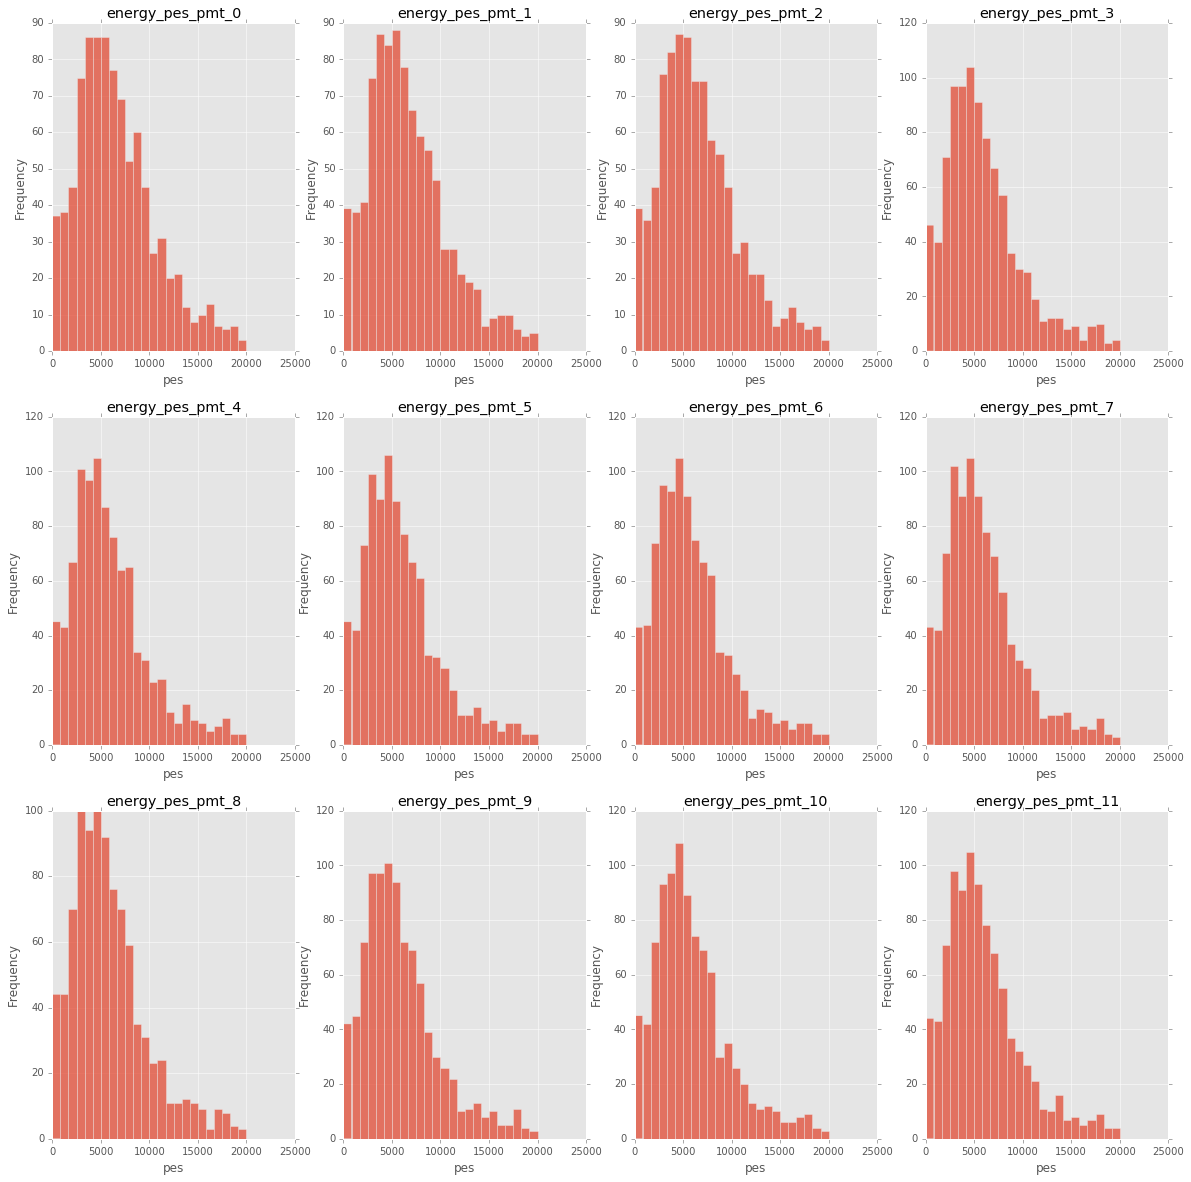

In [33]:
histo_twf_ene(pmtl,emin = 0, emax = 20000, nbins = 25)

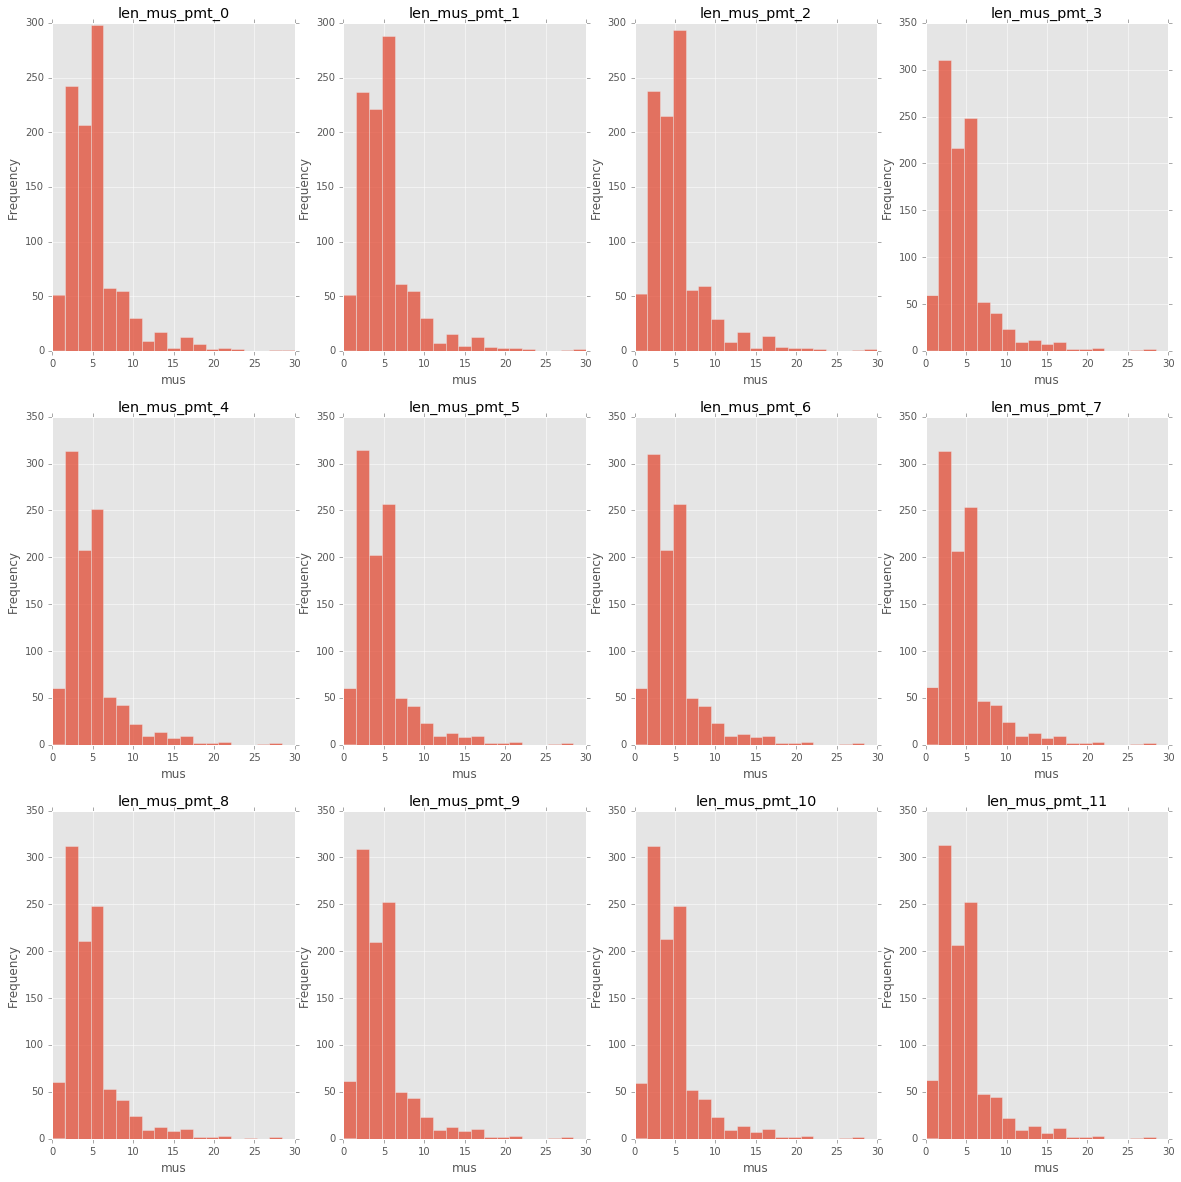

In [36]:
histo_twf_len(pmtl, lmin = 0, lmax = 30, nbins = 20)

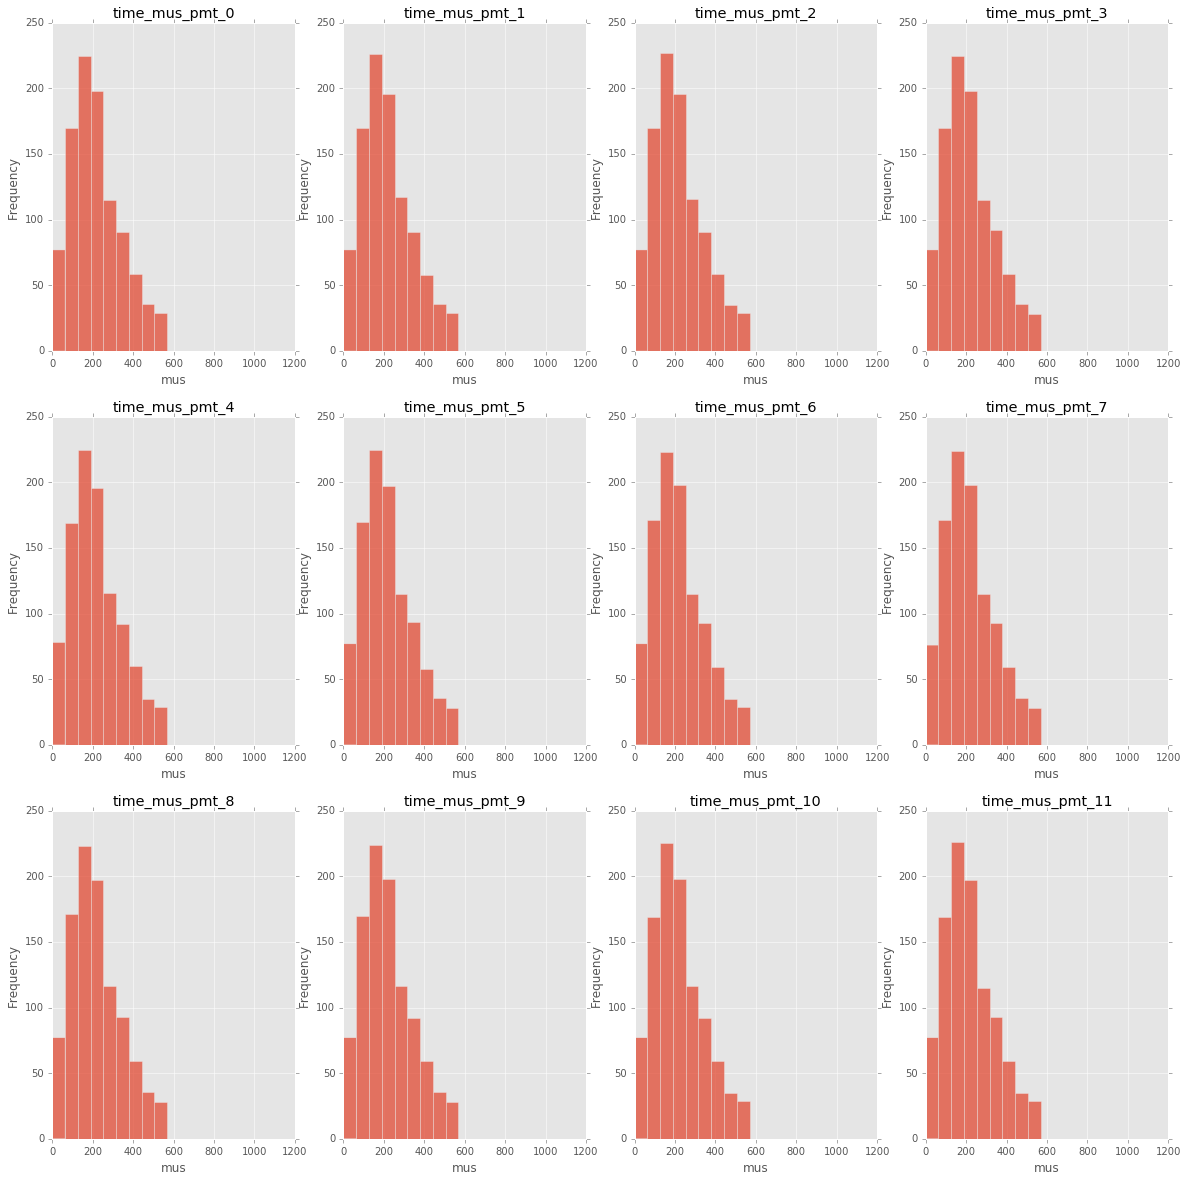

In [37]:
histo_twf_time(pmtl, tmin = 0, tmax = 1200, nbins = 20)

In [43]:
outl = stat_twf_ene(pmtl,emin = 0, emax = 90000)

PMT number 0
count     1000.000000
mean      8593.297000
std       8253.999086
min          5.000000
25%       3840.000000
50%       6392.000000
75%       9814.250000
max      59438.000000
dtype: float64
PMT number 1
count     1000.000000
mean      8585.968000
std       8247.102967
min          4.000000
25%       3863.000000
50%       6370.000000
75%       9816.500000
max      59339.000000
dtype: float64
PMT number 2
count     1000.000000
mean      8585.266000
std       8249.913968
min          3.000000
25%       3866.500000
50%       6375.500000
75%       9823.500000
max      59323.000000
dtype: float64
PMT number 3
count     1000.000000
mean      7303.463000
std       6999.474139
min          3.000000
25%       3297.500000
50%       5432.500000
75%       8410.750000
max      50651.000000
dtype: float64
PMT number 4
count     1000.000000
mean      7302.542000
std       7000.827646
min          5.000000
25%       3281.250000
50%       5412.000000
75%       8328.750000
max      50505.00

### NO WRONG OUTLAYERS